# Setup

In [4]:
import sys
import os
sys.path.append(os.path.abspath('../')) # Point to project root

In [5]:


import importlib
import modules.trainer
import modules.utils
import modules.callbacks
import modules.env
import env.custom_halfcheetah

# Force reload of the modules you changed
importlib.reload(modules.env)
importlib.reload(modules.callbacks)
importlib.reload(modules.utils)
importlib.reload(modules.trainer)
importlib.reload(env.custom_halfcheetah)

# Re-import the specific functions into the global namespace
from modules.trainer import train_agent
from modules.utils import *
from env.custom_halfcheetah import *

print("Modules reloaded successfully!")

Modules reloaded successfully!


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-source-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-target-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\

In [3]:
from modules.trainer import train_agent
from modules.utils import *
from env.custom_halfcheetah import *

#  UDR - Half Cheetah

## Training

In [6]:


HALF_CHEETAH_CONFIG_UDR = config = {
    'env_id': 'CustomHalfCheetah-source-v0',
    'algorithm': 'SAC',
    'seed': 42,
    'timesteps': 1_000_000,
    'n_envs': 4,
    'vectorize': True,
    'normalize': True, 
    'lr': 3*1e-4,
    # DORAEMON Settings
    'use_doraemon': False,    
}

print("=== Training HalfCheetah with UDR ===")
model_udr, env_udr, _ = train_agent(HALF_CHEETAH_CONFIG_UDR, log_dir="./logs/halfcheetah/udr")


=== Training HalfCheetah with UDR ===
--- STARTING NEW TRAINING ---
Using cpu device
--- UDR Mode: Training without DORAEMON ---
Logging to ./tensorboard_logs/SAC_44
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.05e+03 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 225      |
|    time_elapsed    | 17       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -23.5    |
|    critic_loss     | 0.79     |
|    ent_coef        | 0.749    |
|    ent_coef_loss   | -2.82    |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1e+03    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 181      |
|    time_elapsed 

In [7]:
# --- TEST SOURCE ---
source_raw = gym.make('CustomHalfCheetah-source-v0')
m_source = source_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Source: {m_source:.4f}")

# --- TEST TARGET ---
target_raw = gym.make('CustomHalfCheetah-target-v0')
m_target = target_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Target: {m_target:.4f}")

if m_source == m_target:
    print("❌ ERRORE CRITICO: Le masse sono identiche nel simulatore!")
else:
    print("✅ OK: Le masse sono differenziate.")

VERIFICA DIRETTA - Massa Source: 6.2502
VERIFICA DIRETTA - Massa Target: 7.7502
✅ OK: Le masse sono differenziate.


## Evaluation source VS target

In [8]:
# Run evaluation
# Define the raw environments
# # from stable_baselines3 import SAC

norm_path = f"./logs/halfcheetah/udr/final_vecnormalize.pkl"
source_env = gym.make('CustomHalfCheetah-source-v0')

target_env = gym.make('CustomHalfCheetah-target-v0')

evaluate_sim2real(model_udr, source_env, target_env, log_dir="./logs/halfcheetah/udr", model_name="final")

Loaded Normalization stats from ./logs/halfcheetah/udr/final_vecnormalize.pkl


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



--- Evaluating on SOURCE Env (Simulation) ---
Reward: 6426.69 +/- 50.87
Length: 1000.00 +/- 0.00 steps

--- Evaluating on TARGET Env (Real/Shifted) ---
Reward: 6425.58 +/- 52.90
Length: 1000.00 +/- 0.00 steps


(np.float64(6426.685220906138), np.float64(6425.57677898705))

## Render

In [5]:
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
from stable_baselines3 import SAC
#test su 500 timesteps non su 1000->  CustomHalfCheetah-source-v0 ha max_episode_steps=1000. CustomHalfCheetah-shift-v0 (usato per lo shift) ha max_episode_steps=500.
# 1. Crea l'ambiente con render_mode
raw_render_env = gym.make('CustomHalfCheetah-v0', render_mode='human')

# 2. Avvolgilo (NECESSARIO per caricare le statistiche)
render_env = DummyVecEnv([lambda: raw_render_env])

# 3. Carica le statistiche di normalizzazione del training
stats_path = './logs/halfcheetah/udr/final_vecnormalize.pkl'
render_env = VecNormalize.load(stats_path, render_env)

# IMPORTANTE: non aggiornare le medie durante il rendering!
render_env.training = False
render_env.norm_reward = False 

# 4. Carica il modello passandogli l'ambiente normalizzato
model_udr_loaded = SAC.load('./logs/halfcheetah/udr/final_model', env=render_env)

# Run a few episodes
n_episodes = 5
for episode in range(n_episodes):
    obs = render_env.reset() # VecEnv reset ritorna solo obs
    done = [False] # VecEnv lavora con liste di segnali
    total_reward = 0
    
    while not done[0]:
        action, _states = model_udr_loaded.predict(obs, deterministic=True)
        # VecEnv step ritorna (obs, rewards, dones, infos)
        obs, rewards, dones, infos = render_env.step(action)
        
        total_reward += rewards[0]
        done = dones
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

render_env.close()

Episode 1: Total Reward = 6582.19
Episode 2: Total Reward = 6559.49
Episode 3: Total Reward = 6388.98
Episode 4: Total Reward = 6423.69
Episode 5: Total Reward = 6563.18


## Graphs - Robustness Test

### Mass shift

Caricamento modello da: ./logs/halfcheetah/udr\final_model.zip
Environment 'CustomHalfCheetah-shift-v0' registrato correttamente.

Avvio valutazione robustezza su 9 configurazioni...
------------------------------------------------------------

[DEBUG] Shift richiesto: -6.0 kg | MASSA REALE: 0.2502 kg


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-shift-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Shift -6.0 kg | Reward:  2602.75 +/- 111.54

[DEBUG] Shift richiesto: -4.5 kg | MASSA REALE: 1.7502 kg
Shift -4.5 kg | Reward:  2798.23 +/-  70.35

[DEBUG] Shift richiesto: -2.0 kg | MASSA REALE: 4.2502 kg
Shift -2.0 kg | Reward:  3089.28 +/-  45.77

[DEBUG] Shift richiesto: -1.0 kg | MASSA REALE: 5.2502 kg
Shift -1.0 kg | Reward:  3123.60 +/-  43.05

[DEBUG] Shift richiesto: +0.0 kg | MASSA REALE: 6.2502 kg
Shift +0.0 kg | Reward:  3110.71 +/-  34.14

[DEBUG] Shift richiesto: +1.0 kg | MASSA REALE: 7.2502 kg
Shift +1.0 kg | Reward:  3135.19 +/-  32.28

[DEBUG] Shift richiesto: +2.0 kg | MASSA REALE: 8.2502 kg
Shift +2.0 kg | Reward:  3095.21 +/-  39.74

[DEBUG] Shift richiesto: +4.5 kg | MASSA REALE: 10.7502 kg
Shift +4.5 kg | Reward:  2918.75 +/-  38.17

[DEBUG] Shift richiesto: +6.0 kg | MASSA REALE: 12.2502 kg
Shift +6.0 kg | Reward:  2656.78 +/- 509.01


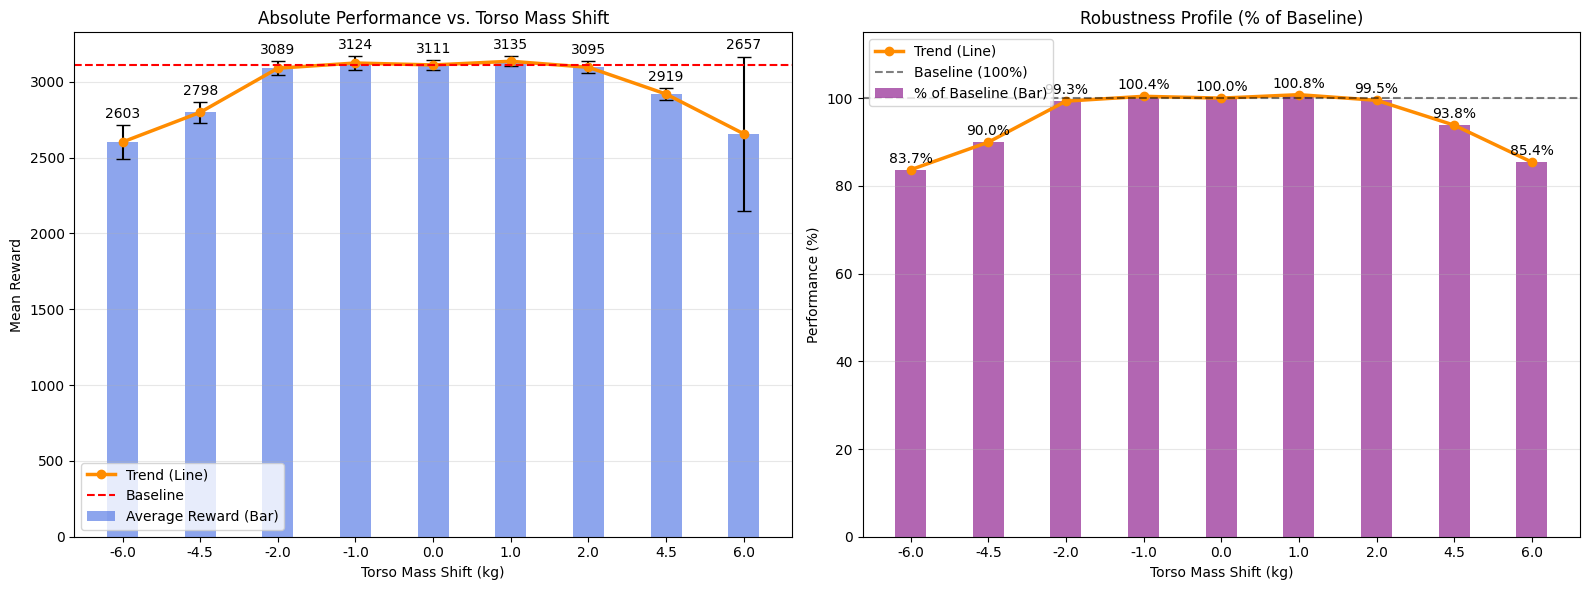

In [ ]:
#test su 500 timesteps non su 1000->  CustomHalfCheetah-source-v0 ha max_episode_steps=1000. CustomHalfCheetah-shift-v0 (usato per lo shift) ha max_episode_steps=500.
# ECCO PERCHE' STATISTICHE NON CORRISPONDONO

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH ---
# Definisci i path una volta sola all'inizio
BASE_RESULTS_PATH = "./logs/halfcheetah/udr"
model_path = os.path.join(BASE_RESULTS_PATH, "final_model.zip")
norm_path = os.path.join(BASE_RESULTS_PATH, "final_vecnormalize.pkl")

# --- 2. CARICAMENTO MODELLO ---
print(f"Caricamento modello da: {model_path}")
model = SAC.load(model_path, device="cpu")

# --- 3. REGISTRAZIONE ENVIRONMENT ---
try:
    register(
        id="CustomHalfCheetah-shift-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500,  # PORTATO A 1000 per coerenza
        kwargs={"domain": "shift", "mass_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-shift-v0' registrato correttamente.")
except:
    pass

# --- 4. CONFIGURAZIONE VALUTAZIONE ---
mass_shifts = [-6.0, -4.5, -2.0, -1.0, 0.0, 1.0, 2.0, 4.5, 6.0]
n_eval_episodes = 20
results_mean = []
results_std = []

print(f"\nAvvio valutazione robustezza su {len(mass_shifts)} configurazioni...")
print("-" * 60)

# --- 5. LOOP DI VALUTAZIONE ---
for shift in mass_shifts:
    # Creazione ambiente base con lo shift specifico
    raw_env = gym.make("CustomHalfCheetah-shift-v0", mass_shift=shift)
    
    # Debug immediato della massa reale
    actual_mass = raw_env.unwrapped.model.body_mass[1]
    
    # Vettorizzazione (necessaria per VecNormalize)
    env = DummyVecEnv([lambda: raw_env])
    
    # CARICAMENTO UNICO DELLA NORMALIZZAZIONE
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True     # <--- FONDAMENTALE per non avere reward a 600
        env.norm_reward = False 
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"\n[DEBUG] Shift richiesto: {shift:+.1f} kg | MASSA REALE: {actual_mass:.4f} kg")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"Shift {shift:+.1f} kg | Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    
    env.close()

# --- 6. PREPARAZIONE DATI PER PLOT ---
results_mean = np.array(results_mean)
results_std = np.array(results_std)
if 0.0 in mass_shifts:
    baseline_idx = mass_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(mass_shifts))

# --- Grafico A: Performance Assoluta ---
# 1. Le Barre
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Torso Mass Shift')
ax1.set_xlabel('Torso Mass Shift (kg)')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(mass_shifts)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()

# Etichette barre
ax1.bar_label(bars1, fmt='%.0f', padding=3)


# --- Grafico B: Performance Relativa ---
# 1. Le Barre
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline)')
ax2.set_xlabel('Torso Mass Shift (kg)')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(mass_shifts)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()

# Etichette barre
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()


### Mass-Friction combined shift - HeatMap

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- CONFIGURAZIONE ---
BASE_RESULTS_PATH = "./logs/halfcheetah/udr"
model_path = os.path.join(BASE_RESULTS_PATH, "final_model.zip")
norm_path = os.path.join(BASE_RESULTS_PATH, "final_vecnormalize.pkl")

# Caricamento modello
print(f"Caricamento modello da: {model_path}")
model = SAC.load(model_path, device="cpu")

#Registrazione environment combinato
try:
    register(
        id="CustomHalfCheetah-combined-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500,
        kwargs={"domain": "combined", "mass_shift": 0.0, "friction_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-combined-v0' registrato correttamente.")
except:
    pass

# --- PARAMETRI DELLA HEATMAP ---
mass_shifts = np.array([-6.0, -4.5, -2.0, -1.0, 0.0, 1.0, 2.0, 4.5, 6.0])
friction_shifts = np.array([-0.4, -0.2, 0.0, 0.2, 0.4, 0.8, 1.0, 2.0])
n_eval_episodes = 20

# Matrice per i risultati
heatmap_data = np.zeros((len(friction_shifts), len(mass_shifts)))
heatmap_std = np.zeros((len(friction_shifts), len(mass_shifts)))

print(f"\nAvvio valutazione combinata su {len(mass_shifts)} masse x {len(friction_shifts)} attriti...")
print(f"Totale configurazioni: {len(mass_shifts) * len(friction_shifts)}")
print("-" * 80)

# --- LOOP DI VALUTAZIONE ---
for i, friction_shift in enumerate(friction_shifts):
    for j, mass_shift in enumerate(mass_shifts):
        # Creazione ambiente con entrambi gli shift
        raw_env = gym.make("CustomHalfCheetah-combined-v0", 
                          mass_shift=mass_shift, 
                          friction_shift=friction_shift)
        
        # Vettorizzazione
        env = DummyVecEnv([lambda e=raw_env: e])
        
        # Caricamento normalizzazione
        if os.path.exists(norm_path):
            env = VecNormalize.load(norm_path, env)
            env.training = False      
            env.norm_obs = True
            env.norm_reward = False 
        
        # Valutazione
        episode_rewards, _ = evaluate_policy(
            model, 
            env, 
            n_eval_episodes=n_eval_episodes, 
            deterministic=True, 
            return_episode_rewards=True
        )
        
        heatmap_data[i, j] = np.mean(episode_rewards)
        heatmap_std[i, j] = np.std(episode_rewards)
        
        print(f"Mass shift: {mass_shift:+6.1f} kg | Friction shift: {friction_shift:+5.2f} | Reward: {heatmap_data[i, j]:8.2f} +/- {heatmap_std[i, j]:6.2f}")
        
        env.close()

# --- CREAZIONE HEATMAP ---
fig, ax = plt.subplots(figsize=(14, 8))

# Usa il reward assoluto per il confronto tra modelli
baseline_idx_mass = np.where(mass_shifts == 0.0)[0][0]
baseline_idx_friction = np.where(friction_shifts == 0.0)[0][0]
baseline_reward = heatmap_data[baseline_idx_friction, baseline_idx_mass]

# Creazione heatmap con reward assoluti
im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', 
               origin='lower', vmin=0, vmax=4000)

# Aggiungi valori assoluti nelle celle
for i in range(len(friction_shifts)):
    for j in range(len(mass_shifts)):
        text = ax.text(j, i, f'{heatmap_data[i, j]:.0f}',
                      ha="center", va="center", color="black", fontsize=8)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Reward', rotation=270, labelpad=20)

# Highlight baseline
rect = plt.Rectangle((baseline_idx_mass - 0.5, baseline_idx_friction - 0.5), 
                     1, 1, fill=False, edgecolor='blue', linewidth=2)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"Baseline reward (mass_shift=0, friction_shift=0): {baseline_reward:.2f}")
print("="*80)

Caricamento modello da: ./logs/halfcheetah/udr\final_model.zip
Environment 'CustomHalfCheetah-combined-v0' registrato correttamente.

Avvio valutazione combinata su 9 masse x 8 attriti...
Totale configurazioni: 72
--------------------------------------------------------------------------------
Mass shift:   -6.0 kg | Friction shift: -0.40 | Reward:  2577.38 +/- 172.89
Mass shift:   -4.5 kg | Friction shift: -0.40 | Reward:  2757.69 +/-  51.39
Mass shift:   -2.0 kg | Friction shift: -0.40 | Reward:  3072.50 +/-  49.87
Mass shift:   -1.0 kg | Friction shift: -0.40 | Reward:  3108.68 +/-  52.13
Mass shift:   +0.0 kg | Friction shift: -0.40 | Reward:  3125.97 +/-  42.86
Mass shift:   +1.0 kg | Friction shift: -0.40 | Reward:  3121.89 +/-  45.99
Mass shift:   +2.0 kg | Friction shift: -0.40 | Reward:  3087.93 +/-  46.70
Mass shift:   +4.5 kg | Friction shift: -0.40 | Reward:  2928.45 +/-  33.22


### Friction shift

Caricamento modello da: ./logs/halfcheetah/udr\final_model.zip
Environment 'CustomHalfCheetah-friction-v0' registrato correttamente.

Avvio valutazione robustezza attrito su 8 configurazioni...
------------------------------------------------------------

[DEBUG] Shift richiesto: -0.40 | FRICTION REALE: 0.0100


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-friction-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Friction shift -0.40 | Reward:  3123.58 +/-  57.38

[DEBUG] Shift richiesto: -0.20 | FRICTION REALE: 0.2000
Friction shift -0.20 | Reward:  3136.92 +/-  56.82

[DEBUG] Shift richiesto: +0.00 | FRICTION REALE: 0.4000
Friction shift +0.00 | Reward:  3166.99 +/-  67.82

[DEBUG] Shift richiesto: +0.20 | FRICTION REALE: 0.6000
Friction shift +0.20 | Reward:  3134.18 +/-  91.75

[DEBUG] Shift richiesto: +0.40 | FRICTION REALE: 0.8000
Friction shift +0.40 | Reward:  2988.75 +/-  63.03

[DEBUG] Shift richiesto: +0.80 | FRICTION REALE: 1.2000
Friction shift +0.80 | Reward:  2835.74 +/-  54.19

[DEBUG] Shift richiesto: +1.00 | FRICTION REALE: 1.4000
Friction shift +1.00 | Reward:  2595.26 +/- 218.53

[DEBUG] Shift richiesto: +2.00 | FRICTION REALE: 2.4000
Friction shift +2.00 | Reward:   936.12 +/-  97.25


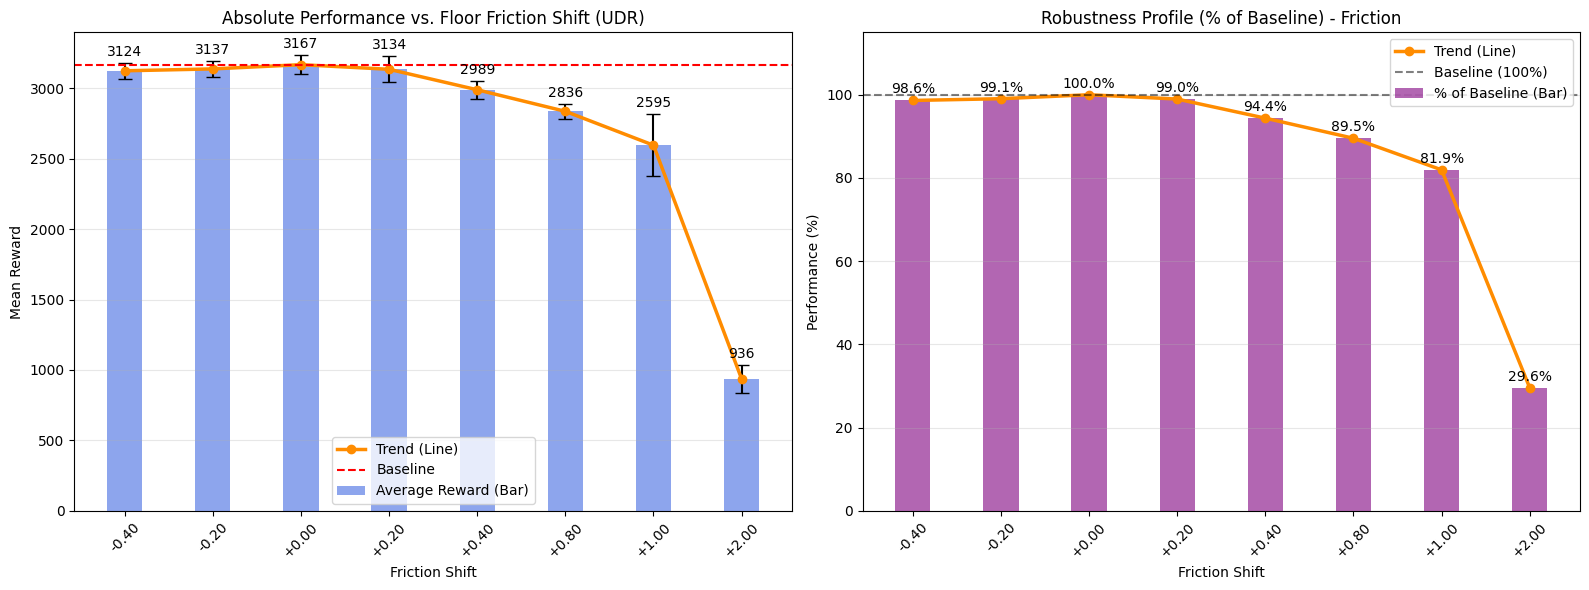

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH ---
BASE_RESULTS_PATH = "./logs/halfcheetah/udr"
model_path = os.path.join(BASE_RESULTS_PATH, "final_model.zip")
norm_path = os.path.join(BASE_RESULTS_PATH, "final_vecnormalize.pkl")

# --- 2. CARICAMENTO MODELLO ---
print(f"Caricamento modello da: {model_path}")
model = SAC.load(model_path, device="cpu")

# --- 3. REGISTRAZIONE ENVIRONMENT CON FRICTION ---
try:
    register(
        id="CustomHalfCheetah-friction-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500,
        kwargs={"domain": "friction", "friction_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-friction-v0' registrato correttamente.")
except:
    pass

# --- 4. CONFIGURAZIONE VALUTAZIONE ---
# Test con variazioni di attrito (valori tipici: 0.4 default in MuJoCo)
# Testiamo da -0.3 a +0.3 (quindi da 0.1 a 0.7)
friction_shifts =   [-0.4, -0.2, 0.0, 0.2, 0.4, 0.8, 1 , 2]
n_eval_episodes = 20
results_mean = []
results_std = []

print(f"\nAvvio valutazione robustezza attrito su {len(friction_shifts)} configurazioni...")
print("-" * 60)

# --- 5. LOOP DI VALUTAZIONE ---
for shift in friction_shifts:
    # Creazione ambiente base con lo shift specifico
    raw_env = gym.make("CustomHalfCheetah-friction-v0", friction_shift=shift)
    
    # Debug attrito
    actual_friction = raw_env.unwrapped.model.geom_friction[0, 0]
    
    # Vettorizzazione
    env = DummyVecEnv([lambda e=raw_env: e])
    
    # CARICAMENTO NORMALIZZAZIONE
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True
        env.norm_reward = False 
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"\n[DEBUG] Shift richiesto: {shift:+.2f} | FRICTION REALE: {actual_friction:.4f}")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"Friction shift {shift:+.2f} | Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    
    env.close()

# --- 6. PREPARAZIONE DATI PER PLOT ---
results_mean = np.array(results_mean)
results_std = np.array(results_std)
if 0.0 in friction_shifts:
    baseline_idx = friction_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(friction_shifts))

# --- Grafico A: Performance Assoluta ---
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Floor Friction Shift (UDR)')
ax1.set_xlabel('Friction Shift')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{s:+.2f}' for s in friction_shifts], rotation=45)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()
ax1.bar_label(bars1, fmt='%.0f', padding=3)

# --- Grafico B: Performance Relativa ---
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline) - Friction')
ax2.set_xlabel('Friction Shift')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{s:+.2f}' for s in friction_shifts], rotation=45)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

# DORAEMON - Half Cheetah

## Training

In [4]:

HALF_CHEETAH_CONFIG_DORAEMON = {
    "env_id": "CustomHalfCheetah-v0",
    "algorithm": "SAC",         # o "PPO"
    'seed': 42,
    'timesteps': 5_000_000,
    'n_envs': 4,
    'vectorize': True,
    'normalize': True, 
    'lr': 3*1e-4,

    # DORAEMON Settings
    'use_doraemon': True,  
    'threshold_reward': 6000,    # Alzato per evitare il collasso della varianza
    'lr_param': 1*1e-2,          # Più veloce nell'adattare i parametri
    'lr_lambda': 5*1e-2,
    'min_std': 0.05,              # Maggiore sicurezza sulla varianza minima
    'target_success':0.7,
    'initial_lambda':1.0,
    'save_interval': 10_000,
}

model_doraemon, env_doraemon, doraemon_cb= train_agent(HALF_CHEETAH_CONFIG_DORAEMON, log_dir="./logs/halfcheetah/doraemon")

--- STARTING NEW TRAINING ---
Using cpu device
Logging to ./tensorboard_logs/SAC_43
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 948      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 205      |
|    time_elapsed    | 19       |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -23      |
|    critic_loss     | 1.03     |
|    ent_coef        | 0.748    |
|    ent_coef_loss   | -2.85    |
|    learning_rate   | 0.0003   |
|    n_updates       | 974      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 981      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 203      |
|    time_elapsed    | 39       |
|    total_timesteps | 8000     |
| train/             |          

In [20]:
# ONLY USE IF TRAINING WAS INTERRUPTED AND YOU HAVE CHECKPOINTS

import os
import re

# CHECKPOINT VERIFICATION

checkpoint_dir = "./logs/halfcheetah/doraemon/checkpoints"
if os.path.exists(checkpoint_dir):
    print("Files found:", os.listdir(checkpoint_dir))
else:
    print("No checkpoints found! The interrupt save didn't work.")


# RESUME TRAINING FROM CHECKPOINT

# 1. Find the latest checkpoint step
log_dir = "./logs/halfcheetah/doraemon"
ckpt_dir = os.path.join(log_dir, "checkpoints")

latest_step = None
if os.path.exists(ckpt_dir):
    # regex to find numbers in filenames
    steps = [int(re.search(r'\d+', f).group()) for f in os.listdir(ckpt_dir) if "model_" in f]
    if steps:
        latest_step = max(steps)

print(f"Resuming from step: {latest_step}")

# 2. Resume Training
if latest_step is not None:
    # Pass the step number to resume_step
    model, env, _ = train_agent(HALF_CHEETAH_CONFIG_DORAEMON, log_dir=log_dir, resume_step=latest_step)
else:
    print("Could not find a checkpoint to resume.")

Files found: ['doraemon_state_3336.json', 'doraemon_state_68040.json', 'doraemon_state_8332.json', 'doraemon_state_848020.json', 'doraemon_state_856812.json', 'model_3336.zip', 'model_68040.zip', 'model_8332.zip', 'model_848020.zip', 'model_856812.zip', 'replay_buffer_3336.pkl', 'replay_buffer_68040.pkl', 'replay_buffer_8332.pkl', 'replay_buffer_848020.pkl', 'replay_buffer_856812.pkl', 'vecnormalize_3336.pkl', 'vecnormalize_68040.pkl', 'vecnormalize_8332.pkl', 'vecnormalize_848020.pkl', 'vecnormalize_856812.pkl']
Resuming from step: 856812
--- RESUMING TRAINING FROM STEP 856812 ---
Loaded VecNormalize stats.
Loaded Model and Replay Buffer.
Restored DORAEMON: Lambda=4.92, Mean=[1.0199999809265137, 0.9600000381469727, 0.9800000190734863, 1.0, 1.0199999809265137, 1.0199999809265137, 1.0], Std=[0.058091700077056885, 0.05926522985100746, 0.05926522985100746, 0.05926522985100746, 0.05926522985100746, 0.05926522985100746, 0.05926522985100746]


In [15]:
# --- TEST SOURCE ---
source_raw = gym.make('CustomHalfCheetah-source-v0')
m_source = source_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Source: {m_source:.4f}")

# --- TEST TARGET ---
target_raw = gym.make('CustomHalfCheetah-target-v0')
m_target = target_raw.unwrapped.model.body_mass[1]
print(f"VERIFICA DIRETTA - Massa Target: {m_target:.4f}")

if m_source == m_target:
    print("❌ ERRORE CRITICO: Le masse sono identiche nel simulatore!")
else:
    print("✅ OK: Le masse sono differenziate.")

VERIFICA DIRETTA - Massa Source: 6.2502
VERIFICA DIRETTA - Massa Target: 7.7502
✅ OK: Le masse sono differenziate.


## Evaluation source VS target

In [5]:
# Run evaluation
# Define the raw environments
source_env = gym.make('CustomHalfCheetah-source-v0')
target_env = gym.make('CustomHalfCheetah-target-v0')

evaluate_sim2real(model_doraemon, source_env, target_env, log_dir="./logs/halfcheetah/doraemon", model_name="final")

Loaded Normalization stats from ./logs/halfcheetah/doraemon/final_vecnormalize.pkl


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



--- Evaluating on SOURCE Env (Simulation) ---
Reward: 8385.34 +/- 98.12
Length: 1000.00 +/- 0.00 steps

--- Evaluating on TARGET Env (Real/Shifted) ---
Reward: 7860.30 +/- 117.02
Length: 1000.00 +/- 0.00 steps


(np.float64(8385.341378830046), np.float64(7860.29848145768))

## Render

In [7]:
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv

# 1. Crea l'ambiente con render_mode
raw_render_env = gym.make('CustomHalfCheetah-v0', render_mode='human')

# 2. Avvolgilo (NECESSARIO per caricare le statistiche)
render_env = DummyVecEnv([lambda: raw_render_env])

# 3. Carica le statistiche di normalizzazione del training
stats_path = './logs/halfcheetah/doraemon/final_vecnormalize.pkl'
render_env = VecNormalize.load(stats_path, render_env)

# IMPORTANTE: non aggiornare le medie durante il rendering!
render_env.training = False
render_env.norm_reward = False 

# 4. Carica il modello passandogli l'ambiente normalizzato
model_doraemon_loaded = SAC.load('./logs/halfcheetah/doraemon/final_model', env=render_env)

# Run a few episodes
n_episodes = 5
for episode in range(n_episodes):
    obs = render_env.reset() # VecEnv reset ritorna solo obs
    done = [False] # VecEnv lavora con liste di segnali
    total_reward = 0
    
    while not done[0]:
        action, _states = model_doraemon_loaded.predict(obs, deterministic=True)
        # VecEnv step ritorna (obs, rewards, dones, infos)
        obs, rewards, dones, infos = render_env.step(action)
        
        total_reward += rewards[0]
        done = dones
    
    print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

render_env.close()

NameError: name 'SAC' is not defined

## Graphs - Robustness Test

### Mass shift

Caricamento modello da .\logs\halfcheetah\doraemon\final_model.zip...
Environment 'CustomHalfCheetah-shift-v0' registrato.

Avvio valutazione su 9 configurazioni...
------------------------------------------------------------
[DEBUG] Shift: -6.0 kg | MASSA REALE: 0.2502 kg


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-shift-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


-> Reward:  3045.31 +/-  86.27
[DEBUG] Shift: -4.5 kg | MASSA REALE: 1.7502 kg
-> Reward:  3513.18 +/-  75.27
[DEBUG] Shift: -2.0 kg | MASSA REALE: 4.2502 kg
-> Reward:  3981.60 +/-  74.41
[DEBUG] Shift: -1.0 kg | MASSA REALE: 5.2502 kg
-> Reward:  4001.03 +/-  37.14
[DEBUG] Shift: +0.0 kg | MASSA REALE: 6.2502 kg
-> Reward:  3958.03 +/-  50.67
[DEBUG] Shift: +1.0 kg | MASSA REALE: 7.2502 kg
-> Reward:  3805.43 +/- 105.50
[DEBUG] Shift: +2.0 kg | MASSA REALE: 8.2502 kg
-> Reward:  3603.39 +/-  74.26
[DEBUG] Shift: +4.5 kg | MASSA REALE: 10.7502 kg
-> Reward:  3344.63 +/-  43.08
[DEBUG] Shift: +6.0 kg | MASSA REALE: 12.2502 kg
-> Reward:  3195.46 +/-  41.04


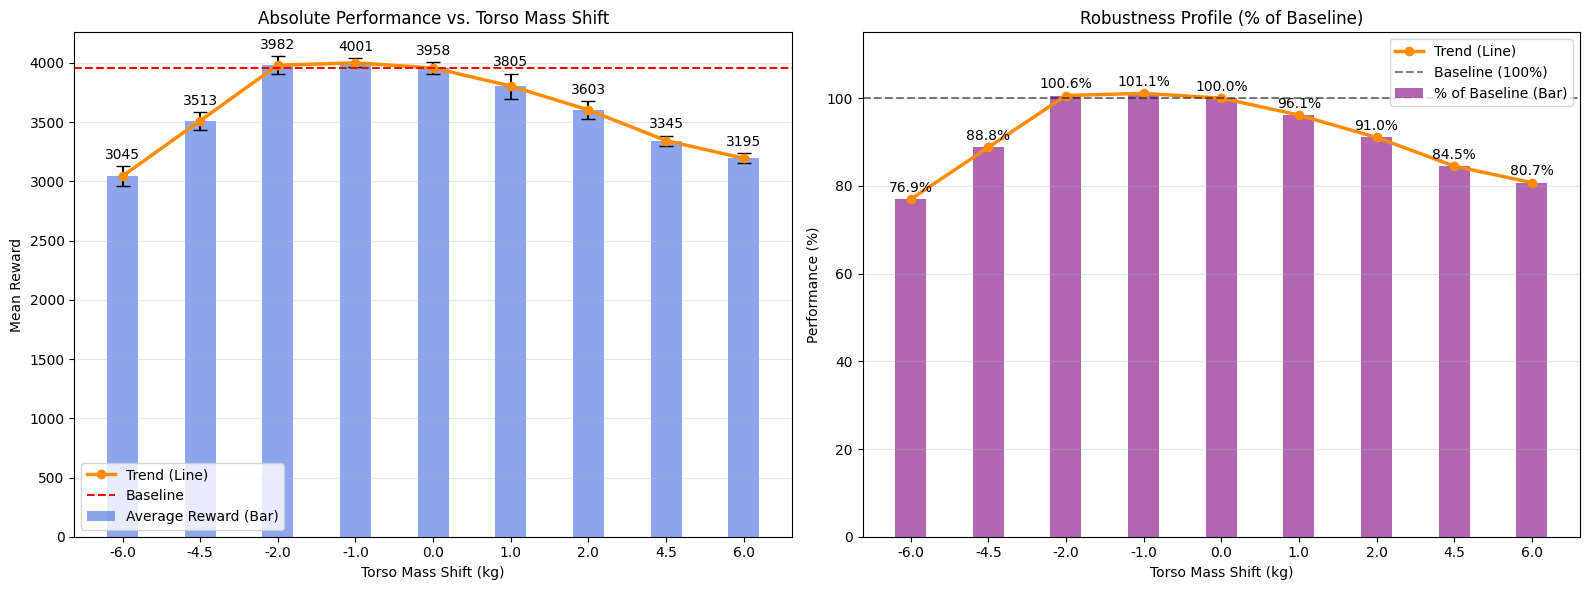

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH E CARICAMENTO ---
# Usa path consistenti
base_path = ".\\logs\\halfcheetah\\doraemon"
model_path = os.path.join(base_path, "final_model.zip")
norm_path = os.path.join(base_path, "final_vecnormalize.pkl")

print(f"Caricamento modello da {model_path}...")
model = SAC.load(model_path, device="cpu")

# --- 2. REGISTRAZIONE ENVIRONMENT ---
try:
    register(
        id="CustomHalfCheetah-shift-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500, # Allineato a SOURCE/TARGET
        kwargs={"domain": "shift", "mass_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-shift-v0' registrato.")
except:
    pass

# --- 3. CONFIGURAZIONE VALUTAZIONE ---
mass_shifts = [-6.0, -4.5, -2.0, -1.0, 0.0, 1.0, 2.0, 4.5, 6.0]
n_eval_episodes = 10 # Ridotto per velocità, aumenta se serve precisione
results_mean = []
results_std = []

print(f"\nAvvio valutazione su {len(mass_shifts)} configurazioni...")
print("-" * 60)

# --- 4. LOOP DI VALUTAZIONE ---
for shift in mass_shifts:
    # Creazione ambiente base
    raw_env = gym.make("CustomHalfCheetah-shift-v0", mass_shift=shift)
    
    # Debug massa (PRIMA dei wrapper per sicurezza)
    actual_mass = raw_env.unwrapped.model.body_mass[1]
    
    # Applicazione Wrapper Vettoriale
    env = DummyVecEnv([lambda: raw_env])
    
    # Caricamento Normalizzazione
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True    # FONDAMENTALE: Attiva la normalizzazione input
        env.norm_reward = False # Non serve normalizzare il reward in eval
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"[DEBUG] Shift: {shift:+.1f} kg | MASSA REALE: {actual_mass:.4f} kg")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"-> Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    env.close()

# --- 5. PLOTTING ---
# (Il tuo codice di plotting va bene, assicurati solo che results_mean sia np.array)
results_mean = np.array(results_mean)
results_std = np.array(results_std)

# ... resto del tuo codice di plotting ...

if 0.0 in mass_shifts:
    baseline_idx = mass_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(mass_shifts))

# --- Grafico A: Performance Assoluta ---
# 1. Le Barre
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Torso Mass Shift')
ax1.set_xlabel('Torso Mass Shift (kg)')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(mass_shifts)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()

# Etichette barre
ax1.bar_label(bars1, fmt='%.0f', padding=3)


# --- Grafico B: Performance Relativa ---
# 1. Le Barre
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline)')
ax2.set_xlabel('Torso Mass Shift (kg)')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(mass_shifts)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()

# Etichette barre
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

### Friction shift


Caricamento modello da .\logs\halfcheetah\doraemon\final_model.zip...
Environment 'CustomHalfCheetah-friction-v0' registrato.

Avvio valutazione su 8 configurazioni...
------------------------------------------------------------
[DEBUG] Shift: -0.40 | FRICTION REALE: 0.0100


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-friction-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


-> Reward:  3935.79 +/-  54.39
[DEBUG] Shift: -0.20 | FRICTION REALE: 0.2000
-> Reward:  3987.00 +/-  69.36
[DEBUG] Shift: +0.00 | FRICTION REALE: 0.4000
-> Reward:  3947.12 +/-  60.47
[DEBUG] Shift: +0.20 | FRICTION REALE: 0.6000
-> Reward:  4000.75 +/-  45.61
[DEBUG] Shift: +0.40 | FRICTION REALE: 0.8000
-> Reward:  3899.18 +/-  59.11
[DEBUG] Shift: +0.80 | FRICTION REALE: 1.2000
-> Reward:  3273.03 +/-  55.69
[DEBUG] Shift: +1.00 | FRICTION REALE: 1.4000
-> Reward:  2849.78 +/- 469.87
[DEBUG] Shift: +2.00 | FRICTION REALE: 2.4000
-> Reward:   645.45 +/-  70.82


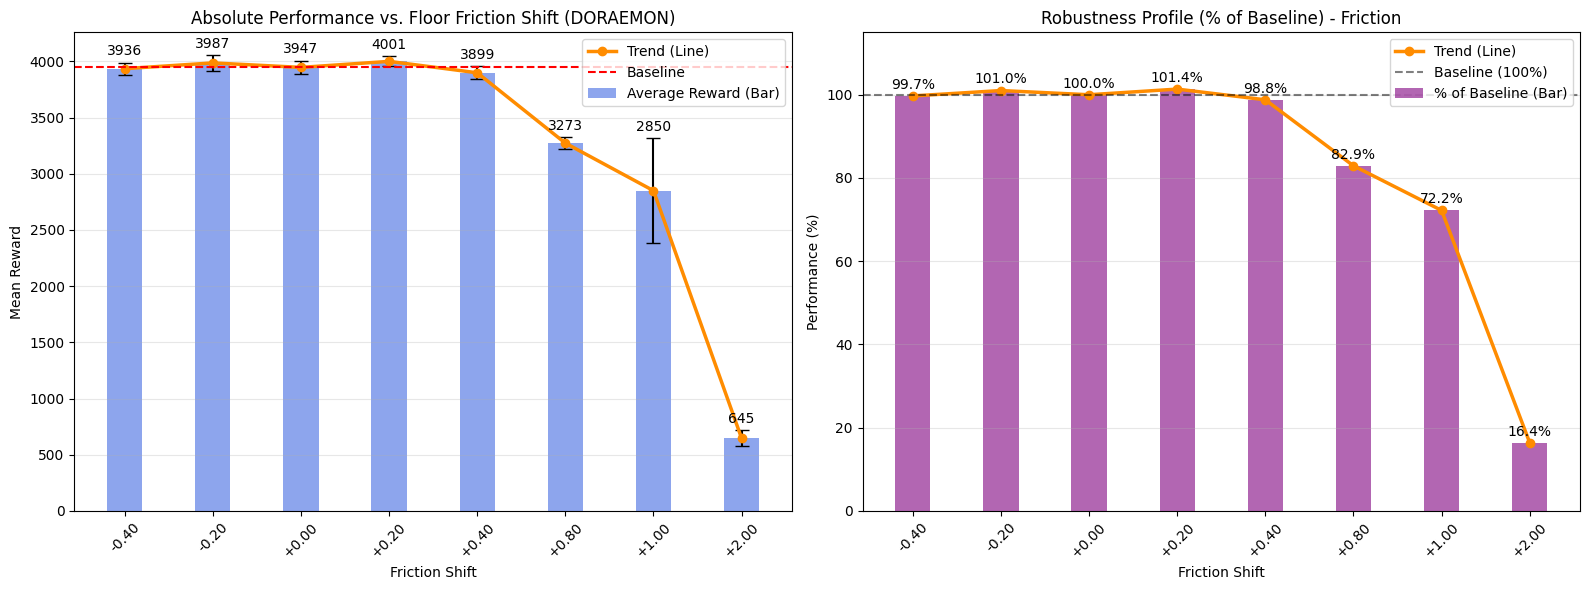

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- 1. CONFIGURAZIONE PATH E CARICAMENTO ---
base_path = ".\\logs\\halfcheetah\\doraemon"
model_path = os.path.join(base_path, "final_model.zip")
norm_path = os.path.join(base_path, "final_vecnormalize.pkl")

print(f"Caricamento modello da {model_path}...")
model = SAC.load(model_path, device="cpu")

# --- 2. REGISTRAZIONE ENVIRONMENT ---
try:
    register(
        id="CustomHalfCheetah-friction-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500,
        kwargs={"domain": "friction", "friction_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-friction-v0' registrato.")
except:
    pass

# --- 3. CONFIGURAZIONE VALUTAZIONE ---
# sul ghiaccio
friction_shifts = [-0.4, -0.2, 0.0, 0.2, 0.4, 0.8, 1 , 2]
n_eval_episodes = 10
results_mean = []
results_std = []

print(f"\nAvvio valutazione su {len(friction_shifts)} configurazioni...")
print("-" * 60)

# --- 4. LOOP DI VALUTAZIONE ---
for shift in friction_shifts:
    # Creazione ambiente base
    raw_env = gym.make("CustomHalfCheetah-friction-v0", friction_shift=shift)
    
    # Debug attrito
    actual_friction = raw_env.unwrapped.model.geom_friction[0, 0]
    
    # Applicazione Wrapper Vettoriale
    env = DummyVecEnv([lambda e=raw_env: e])
    
    # Caricamento Normalizzazione
    if os.path.exists(norm_path):
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_obs = True
        env.norm_reward = False
    else:
        print(f"ATTENZIONE: Statistiche non trovate in {norm_path}")

    print(f"[DEBUG] Shift: {shift:+.2f} | FRICTION REALE: {actual_friction:.4f}")

    # Valutazione
    episode_rewards, _ = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"-> Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    env.close()

# --- 5. PLOTTING ---
results_mean = np.array(results_mean)
results_std = np.array(results_std)

if 0.0 in friction_shifts:
    baseline_idx = friction_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(friction_shifts))

# --- Grafico A: Performance Assoluta ---
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Floor Friction Shift (DORAEMON)')
ax1.set_xlabel('Friction Shift')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'{s:+.2f}' for s in friction_shifts], rotation=45)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()
ax1.bar_label(bars1, fmt='%.0f', padding=3)

# --- Grafico B: Performance Relativa ---
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline) - Friction')
ax2.set_xlabel('Friction Shift')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'{s:+.2f}' for s in friction_shifts], rotation=45)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

### Mass-Friction shift - HeatMap

Caricamento modello da: ./logs/halfcheetah/udr\final_model.zip
Environment 'CustomHalfCheetah-combined-v0' registrato correttamente.

Avvio valutazione combinata su 9 masse x 8 attriti...
Totale configurazioni: 72
--------------------------------------------------------------------------------


c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\gymnasium\envs\registration.py:636: UserWarning: WARN: Overriding environment CustomHalfCheetah-combined-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\irene\OneDrive - Politecnico di Torino\02_robot_learning\project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mass shift:   -6.0 kg | Friction shift: -0.40 | Reward:  2546.59 +/- 149.74
Mass shift:   -4.5 kg | Friction shift: -0.40 | Reward:  2765.11 +/-  72.94
Mass shift:   -2.0 kg | Friction shift: -0.40 | Reward:  3090.02 +/-  39.14
Mass shift:   -1.0 kg | Friction shift: -0.40 | Reward:  3119.52 +/-  33.23
Mass shift:   +0.0 kg | Friction shift: -0.40 | Reward:  3127.15 +/-  33.71
Mass shift:   +1.0 kg | Friction shift: -0.40 | Reward:  3131.94 +/-  57.72
Mass shift:   +2.0 kg | Friction shift: -0.40 | Reward:  3097.82 +/-  56.92
Mass shift:   +4.5 kg | Friction shift: -0.40 | Reward:  2927.94 +/-  35.19
Mass shift:   +6.0 kg | Friction shift: -0.40 | Reward:  2743.55 +/- 357.25
Mass shift:   -6.0 kg | Friction shift: -0.20 | Reward:  2559.96 +/- 170.60
Mass shift:   -4.5 kg | Friction shift: -0.20 | Reward:  2782.32 +/-  78.58
Mass shift:   -2.0 kg | Friction shift: -0.20 | Reward:  3101.63 +/-  45.96
Mass shift:   -1.0 kg | Friction shift: -0.20 | Reward:  3123.25 +/-  55.88
Mass shift: 

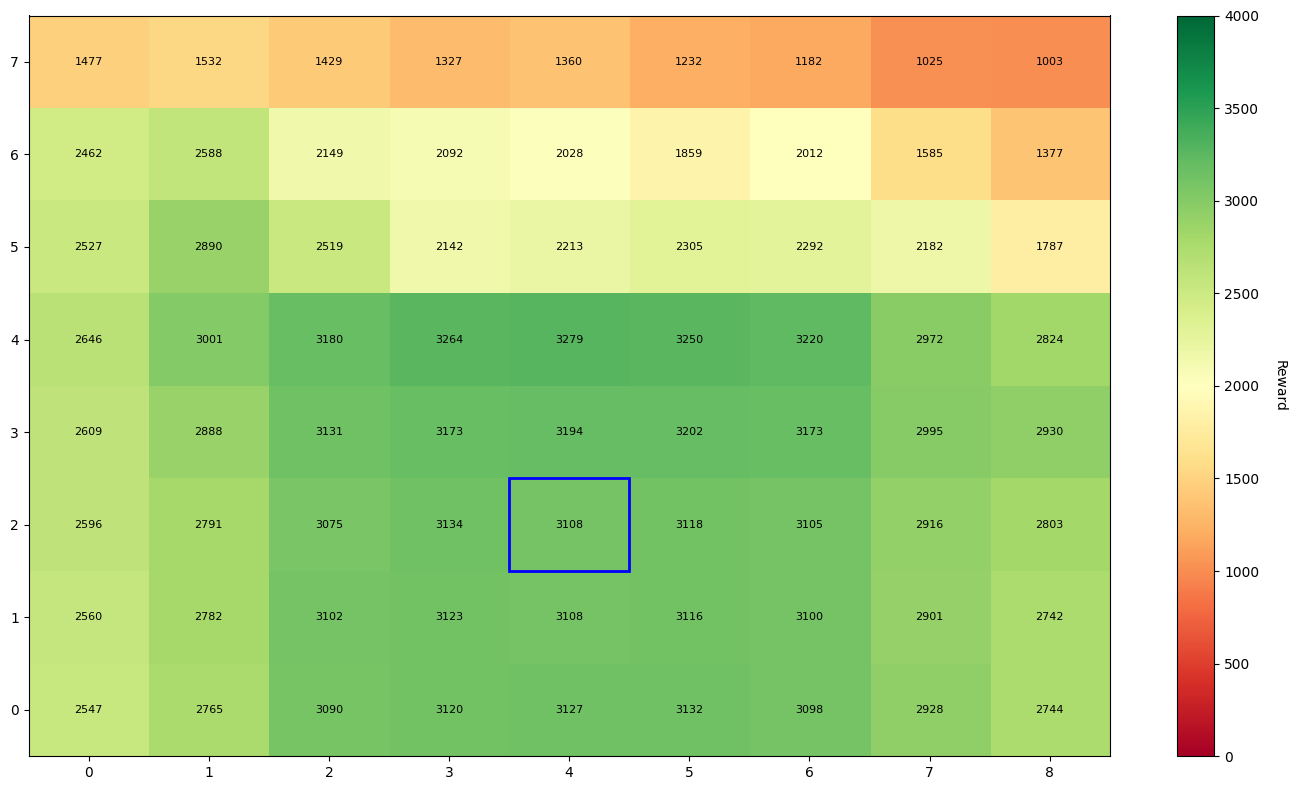


Baseline reward (mass_shift=0, friction_shift=0): 3108.17


In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
import os

# --- CONFIGURAZIONE ---
BASE_RESULTS_PATH = "./logs/halfcheetah/doraemon"
model_path = os.path.join(BASE_RESULTS_PATH, "final_model.zip")
norm_path = os.path.join(BASE_RESULTS_PATH, "final_vecnormalize.pkl")

# Caricamento modello
print(f"Caricamento modello da: {model_path}")
model = SAC.load(model_path, device="cpu")

#Registrazione environment combinato
try:
    register(
        id="CustomHalfCheetah-combined-v0",
        entry_point=CustomHalfCheetah, 
        max_episode_steps=500,
        kwargs={"domain": "combined", "mass_shift": 0.0, "friction_shift": 0.0}
    )
    print("Environment 'CustomHalfCheetah-combined-v0' registrato correttamente.")
except:
    pass

# --- PARAMETRI DELLA HEATMAP ---
mass_shifts = np.array([-6.0, -4.5, -2.0, -1.0, 0.0, 1.0, 2.0, 4.5, 6.0])
friction_shifts = np.array([-0.4, -0.2, 0.0, 0.2, 0.4, 0.8, 1.0, 2.0])
n_eval_episodes = 20

# Matrice per i risultati
heatmap_data = np.zeros((len(friction_shifts), len(mass_shifts)))
heatmap_std = np.zeros((len(friction_shifts), len(mass_shifts)))

print(f"\nAvvio valutazione combinata su {len(mass_shifts)} masse x {len(friction_shifts)} attriti...")
print(f"Totale configurazioni: {len(mass_shifts) * len(friction_shifts)}")
print("-" * 80)

# --- LOOP DI VALUTAZIONE ---
for i, friction_shift in enumerate(friction_shifts):
    for j, mass_shift in enumerate(mass_shifts):
        # Creazione ambiente con entrambi gli shift
        raw_env = gym.make("CustomHalfCheetah-combined-v0", 
                          mass_shift=mass_shift, 
                          friction_shift=friction_shift)
        
        # Vettorizzazione
        env = DummyVecEnv([lambda e=raw_env: e])
        
        # Caricamento normalizzazione
        if os.path.exists(norm_path):
            env = VecNormalize.load(norm_path, env)
            env.training = False      
            env.norm_obs = True
            env.norm_reward = False 
        
        # Valutazione
        episode_rewards, _ = evaluate_policy(
            model, 
            env, 
            n_eval_episodes=n_eval_episodes, 
            deterministic=True, 
            return_episode_rewards=True
        )
        
        heatmap_data[i, j] = np.mean(episode_rewards)
        heatmap_std[i, j] = np.std(episode_rewards)
        
        print(f"Mass shift: {mass_shift:+6.1f} kg | Friction shift: {friction_shift:+5.2f} | Reward: {heatmap_data[i, j]:8.2f} +/- {heatmap_std[i, j]:6.2f}")
        
        env.close()

# --- CREAZIONE HEATMAP ---
fig, ax = plt.subplots(figsize=(14, 8))

# Usa il reward assoluto per il confronto tra modelli
baseline_idx_mass = np.where(mass_shifts == 0.0)[0][0]
baseline_idx_friction = np.where(friction_shifts == 0.0)[0][0]
baseline_reward = heatmap_data[baseline_idx_friction, baseline_idx_mass]

# Creazione heatmap con reward assoluti
im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', 
               origin='lower', vmin=0, vmax=4000)

# Aggiungi valori assoluti nelle celle
for i in range(len(friction_shifts)):
    for j in range(len(mass_shifts)):
        text = ax.text(j, i, f'{heatmap_data[i, j]:.0f}',
                      ha="center", va="center", color="black", fontsize=8)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Reward', rotation=270, labelpad=20)

# Highlight baseline
rect = plt.Rectangle((baseline_idx_mass - 0.5, baseline_idx_friction - 0.5), 
                     1, 1, fill=False, edgecolor='blue', linewidth=2)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"Baseline reward (mass_shift=0, friction_shift=0): {baseline_reward:.2f}")
print("="*80)
